In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
prng = np.random.RandomState(10)

In [4]:
from cgpm2.transition_crosscat import GibbsCrossCat

In [5]:
from cgpm2.flexible_rowmix import FlexibleRowMixture
from cgpm2.product import Product
from cgpm2.crp import CRP
from cgpm2.normal import Normal
from cgpm2.categorical import Categorical

### Basic univariate 3 component mixture 

In [6]:
data0 = prng.normal(loc=0, scale=2, size=20)
data1 = prng.normal(loc=30, scale=1, size=20)
data2 = prng.normal(loc=-30, scale=1, size=20)

In [7]:
data = np.concatenate((data0, data1, data2))

In [8]:
view = FlexibleRowMixture(
    cgpm_row_divide=CRP([-1], [], rng=prng),
    cgpm_components_base=Product(cgpms=[Normal([0], [], rng=prng)]),
    rng=prng)
crosscat = Product(cgpms=[view])

In [9]:
for rowid, value in enumerate(data):
    crosscat.incorporate(rowid, {0: value})

In [10]:
inference = GibbsCrossCat(crosscat, prng)

In [11]:
from cgpm2 import transition_crosscat

In [12]:
%%timeit -n1 -r1
for step in xrange(500):
    inference.transition_row_assignments()
    inference.transition_hypers_distributions()
    inference.transition_hypers_row_divide()

1 loop, best of 1: 13.3 s per loop


In [13]:
crosscat = inference.crosscat

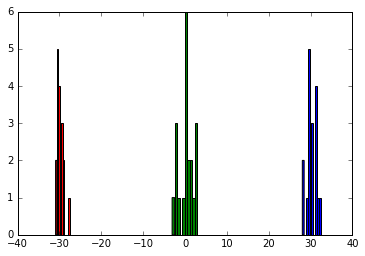

In [14]:
assignments = inference.crosscat.cgpms[0].cgpm_row_divide.data
counts = inference.crosscat.cgpms[0].cgpm_row_divide.counts
fig, ax = plt.subplots()
for cluster in counts:
    rowids = [rowid for rowid, z in assignments.iteritems() if z == cluster]
    ax.hist(data[rowids])

In [15]:
samples = crosscat.simulate(None, [-1,0], N=100)

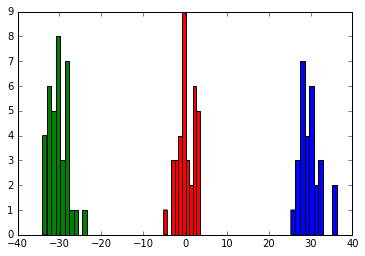

In [16]:
fig, ax = plt.subplots()
zs = set([s[-1] for s in samples])
for z in zs:
    xs = [s[0] for s in samples if s[-1] == z]
    ax.hist(xs)

### Basic bivariate 2 component mixture with DPMM 

In [17]:
view = FlexibleRowMixture(
    cgpm_row_divide=CRP([-1], [], rng=prng),
    cgpm_components_base=Product([
        Normal([0], [], rng=prng),
        Normal([1], [], rng=prng),
    ]),
    rng=prng)
crosscat = Product(cgpms=[view])

In [18]:
df = pd.read_csv('resources/two_clusters.csv', index_col=False)

In [19]:
df.loc[0,'x'] = df.loc[50,'y'] = np.nan
df.loc[10,'x'] = df.loc[30,'y'] = np.nan
df.loc[33,'x'] = df.loc[33,'y'] = np.nan

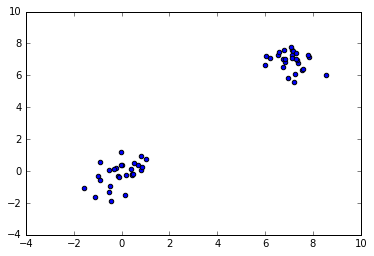

In [20]:
fig, ax = plt.subplots()
ax.scatter(df.x, df.y)

In [21]:
for rowid, row in df.iterrows():
    crosscat.incorporate(rowid, {0: row.x, 1: row.y})

In [22]:
inference = GibbsCrossCat(crosscat, prng)

In [23]:
%%timeit -n1 -r1
for step in xrange(800):
    print '\r%d' % (step,),
    import sys; sys.stdout.flush()
    inference.transition_hypers_distributions()
    inference.transition_hypers_row_divide()
    inference.transition_row_assignments()

799                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             1 loop, best of 1: 33.3 s per loop



OrderedDict([(3, 30), (4, 23), (5, 7)])


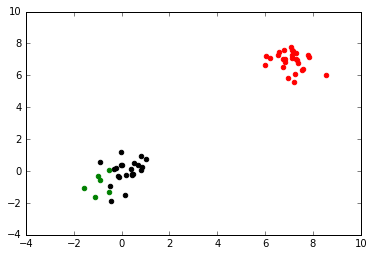

In [24]:
assignments = inference.crosscat.cgpms[0].cgpm_row_divide.data
counts = inference.crosscat.cgpms[0].cgpm_row_divide.counts
print counts
fig, ax = plt.subplots()
for cluster,color in zip(counts, ['r','k','g','y','b']):
    rowids = [rowid for rowid, z in assignments.iteritems() if z == cluster]
    ax.scatter(df.loc[rowids].x, df.loc[rowids].y, color=color)

In [25]:
samples = inference.crosscat.simulate(None, [-1,0, 1], N=100)

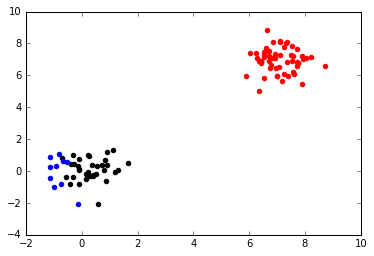

In [26]:
fig, ax = plt.subplots()
zs = set([s[-1] for s in samples])
for z, c in zip(zs, ['r','k','b','g']):
    xs = [s[0] for s in samples if s[-1] == z]
    ys = [s[1] for s in samples if s[-1] == z]
    ax.scatter(xs,ys, color=c)

### Basic bivariate 2 component mixture with CrossCat and category inference

In [27]:
crosscat = Product([
    FlexibleRowMixture(
        cgpm_row_divide=CRP([-1], [], rng=prng),
        cgpm_components_base=Product([
            Normal([10], [], rng=prng),
        ]),
        rng=prng),
    FlexibleRowMixture(
        cgpm_row_divide=CRP([-2], [], rng=prng),
        cgpm_components_base=Product([
            Normal([11], [], rng=prng),
        ]),
        rng=prng),
])

In [28]:
for rowid, row in df.iterrows():
    crosscat.incorporate(rowid, {10: row.x, 11: row.y})

In [29]:
inference = GibbsCrossCat(crosscat, prng)

In [30]:
for step in xrange(100):
    inference.transition_row_assignments()
    inference.transition_hypers_row_divide()
    inference.transition_hypers_distributions()
    inference.transition_view_assignments()

In [31]:
for step in xrange(300):
    inference.transition_row_assignments()
    inference.transition_hypers_row_divide()
    inference.transition_hypers_distributions()

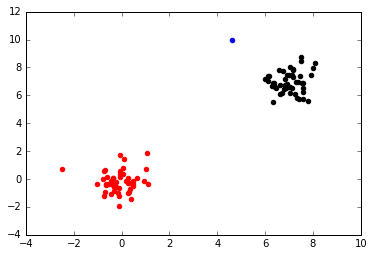

In [32]:
crp_output = inference.crosscat.cgpms[0].cgpm_row_divide.outputs[0]
samples = inference.crosscat.simulate(None, [crp_output,10,11], N=100)
fig, ax = plt.subplots()
zs = set([s[crp_output] for s in samples])
for z, c in zip(zs, ['r','k','b','g']):
    xs = [s[10] for s in samples if s[crp_output] == z]
    ys = [s[11] for s in samples if s[crp_output] == z]
    ax.scatter(xs,ys, color=c)

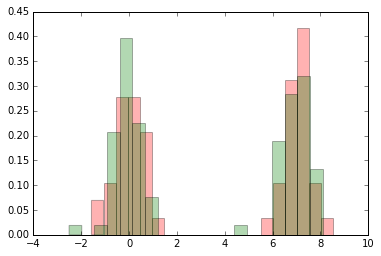

In [33]:
fig, ax = plt.subplots()
ax.hist(df['x'].dropna(), bins=20, normed=True, alpha=0.3, color='r');
ax.hist([s[10] for s in samples], bins=20, normed=True, alpha=0.3, color='g');

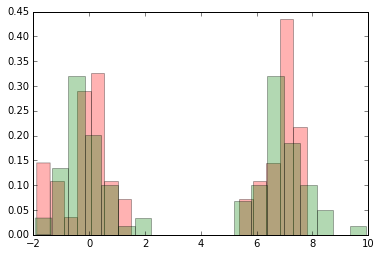

In [34]:
fig, ax = plt.subplots()
ax.hist(df['y'].dropna(), bins=20, normed=True, alpha=0.3, color='r');
ax.hist([s[11] for s in samples], bins=20, normed=True, alpha=0.3, color='g');

#### Some deterministic mutation

In [35]:
cgpms = transition_crosscat.get_distribution_cgpms(inference.crosscat, [10])[10]
for v in np.linspace(0.01,10,1):
    inference.set_hypers_distribution(10, {'m':v})
    for cgpm in cgpms:
        assert cgpm.get_hypers()['m'] == v

In [36]:
for v in np.linspace(0.01,10,1):
    inference.set_hypers_row_divide(10, {'alpha':v})
    assert inference.crosscat.cgpms[0].cgpm_row_divide.get_hypers()['alpha'] == v

In [37]:
inference.set_view_assignment(10,None)
assert len(inference.crosscat.cgpms) == 2

In [38]:
inference.set_view_assignment(11,10)
assert len(inference.crosscat.cgpms) == 1

In [39]:
inference.set_rowid_component(0, 1, None)
inference.set_rowid_component(0, 1, None)

### Basic bivariate 2 component mixture with CrossCat and category inference and nominal variable

In [40]:
df['z'] = 0
df.loc[:15,'z'] = 0
df.loc[15:30,'z'] = 1
df.loc[30:45,'z'] = 2
df.loc[45:60,'z'] = 3

In [41]:
crosscat = Product([
    FlexibleRowMixture(
        cgpm_row_divide=CRP([-1], [], rng=prng),
        cgpm_components_base=Product([
            Normal([10], [], rng=prng),
        ]),
        rng=prng),
    FlexibleRowMixture(
        cgpm_row_divide=CRP([-2], [], rng=prng),
        cgpm_components_base=Product([
            Normal([11], [], rng=prng),
            Categorical([50], [], distargs={'k':4}, rng=prng),
        ]),
        rng=prng),
])

In [42]:
for rowid, row in df.iterrows():
    crosscat.incorporate(rowid, {10: row.x, 11: row.y, 50:row.z})

In [43]:
inference = GibbsCrossCat(crosscat, prng)
inference.transition(N=100)

[==============================] 100.00%

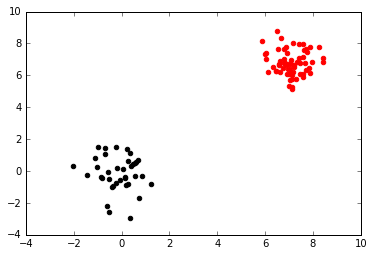

In [44]:
crp_output = inference.crosscat.cgpms[0].cgpm_row_divide.outputs[0]
samples = inference.crosscat.simulate(None, [crp_output,10,11], N=100)
fig, ax = plt.subplots()
zs = set([s[crp_output] for s in samples])
for z, c in zip(zs, ['r','k','b','g']):
    xs = [s[10] for s in samples if s[crp_output] == z]
    ys = [s[11] for s in samples if s[crp_output] == z]
    ax.scatter(xs,ys, color=c)

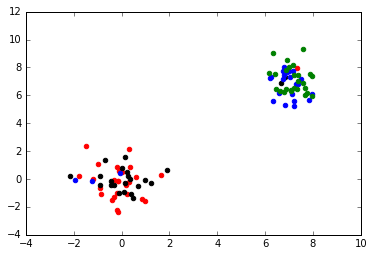

In [45]:
crp_output = inference.crosscat.cgpms[0].cgpm_row_divide.outputs[0]
samples = inference.crosscat.simulate(None, [crp_output,10,11,50], N=100)
fig, ax = plt.subplots()
for z, c in zip([0,1,2,3], ['r','k','b','g']):
    xs = [s[10] for s in samples if s[50] == z]
    ys = [s[11] for s in samples if s[50] == z]
    ax.scatter(xs,ys, color=c)

In [46]:
inference.transition(N=100, kernels=['hypers_distributions','hypers_row_divide'])

[==============================] 100.00%

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


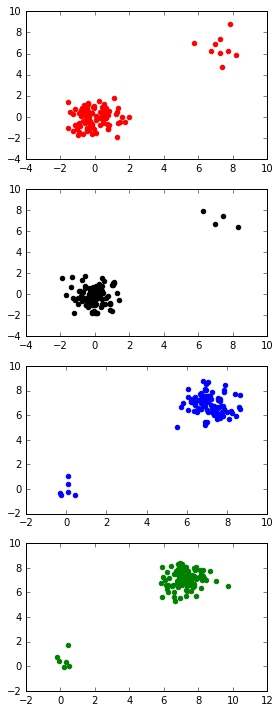

In [47]:
fig, axes = plt.subplots(nrows=4)
for ax, z, c in zip(axes, [0,1,2,3], ['r','k','b','g']):
    samples = inference.crosscat.simulate(None, [10,11], {50:z}, N=100)
    xs = [s[10] for s in samples]
    ys = [s[11] for s in samples]
    ax.scatter(xs,ys, color=c)
fig.set_size_inches(4,10)
fig.set_tight_layout(True)